In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split

# Loading data

In [45]:
df_raw = pd.read_csv('../data/interim/preproc.csv', index_col=0)

## Cleaning Data

In [49]:
# Remove entries with no data and outliers
df = df_raw[(df_raw["num_commits"]>0) & (df_raw["num_commits"]<3e5)].dropna()

# Select relevant projects
good_projects = [proj for proj in set(df['project_id']) if sum(df['project_id'] == proj) > 500]
df = df[df['project_id'].isin(good_projects)]

# Generate new variables
df['lines_modified'] = df['lines_added'] + df['lines_removed']
df = df.reset_index(drop=True)
df.head()

,key,project_id,creation_date,resolution_date,type,num_commits,lines_added,lines_removed,files_changed,duration,text,inter_text,lines_modified
0,ACCUMULO-4854,accumulo,2018-08-26T00:55:43.000+0000,2018-09-04T19:28:08.000+0000,Improvement,1,3,7,1,234.540278,dfslogger exception verbose dfslogger constant...,dfslogger exceptions are too verbose the dfslo...,10
1,ACCUMULO-4847,accumulo,2018-03-14T17:02:47.000+0000,2018-03-14T20:46:09.000+0000,Bug,2,705,559,10,3.722778,fix retry api accumulo exposed merge bug accum...,fix retry api accumulo 4834 exposed a merge bu...,1264
2,ACCUMULO-4836,accumulo,2018-03-01T14:59:21.000+0000,2018-03-19T18:56:29.000+0000,Bug,1,2,0,1,435.952222,table always wait online offline investigating...,tables do not always wait for online or offlin...,2
3,ACCUMULO-4835,accumulo,2018-02-28T17:54:40.000+0000,2018-03-06T20:11:17.000+0000,Bug,1,5,2,1,146.276944,client throw tablenotfoundexception saw mislea...,client should throw tablenotfoundexception i s...,7
4,ACCUMULO-4834,accumulo,2018-02-28T06:06:02.000+0000,2018-03-16T21:57:54.000+0000,Improvement,1,5,0,1,399.864444,locatorit timeout frequently hang locatorit ke...,locatorit has no timeout and frequently hangs ...,5


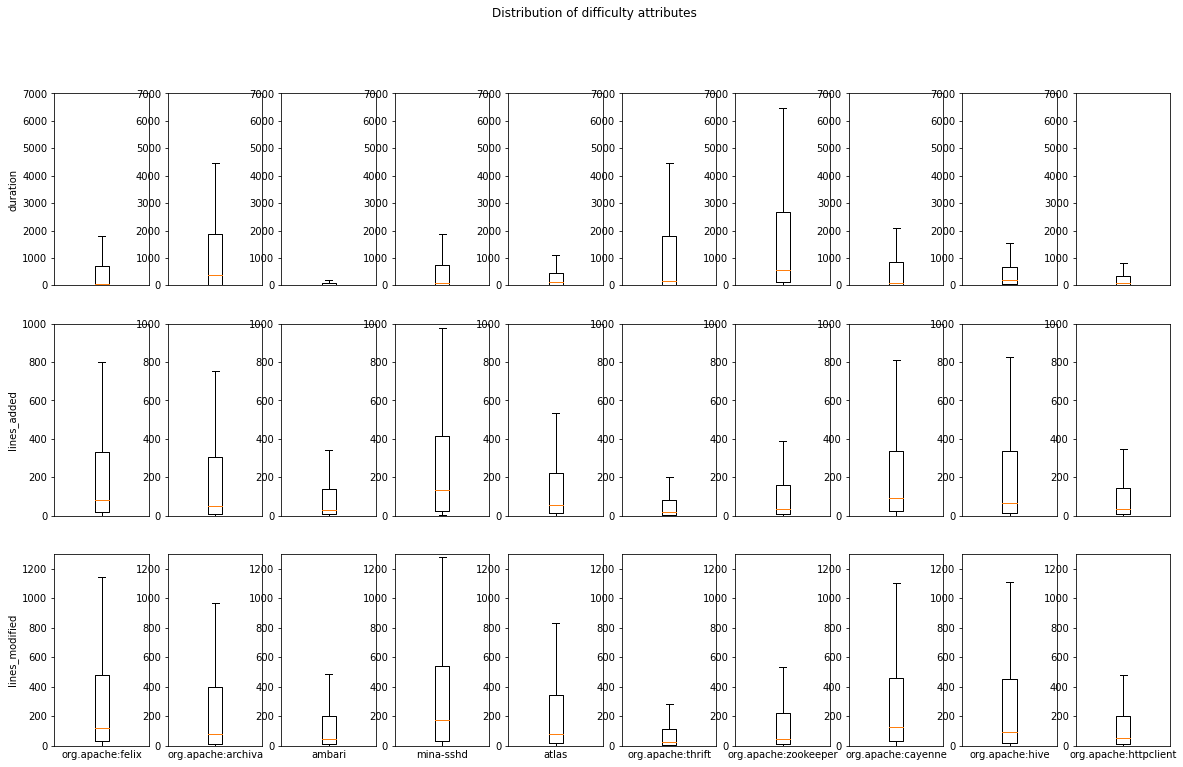

In [51]:
projects = list(set(df['project_id']))[0:10]
fig, ax = plt.subplots(3, len(projects))
fig.set_size_inches((20, 12))
attrs = ['duration', 'lines_added', 'lines_modified']
maxYValue = { "duration": 7000, "lines_added": 1000, 'lines_modified': 1300 }
for j, attr in enumerate(attrs):
    for i, proj in enumerate(projects):
        ax[j,i].boxplot(df[df['project_id'] == proj][attr], showfliers=False);
        ax[j,i].axis(ymin=0, ymax=maxYValue[attr])
        ax[j,i].tick_params(axis='x', which='both', bottom=False, labelbottom=False)
        if j == 2:
            ax[j,i].set_xlabel(proj)
        if i == 0:
            ax[j,i].set_ylabel(attr)
fig.suptitle("Distribution of difficulty attributes");

# Building training Dataset

## Triain/Test split

In [54]:
X_train, X_test = train_test_split(df, test_size=0.20, random_state=123)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

## Quantizing the target variable

In [97]:
nclass = 3
varname = 'lines_added'

sorted_vals = df[varname].sort_values(ignore_index=True).values
nvals = len(sorted_vals)
inter_limits = [sorted_vals[int((i+1)/nclass*nvals)] for i in range(nclass-1)]
limits = np.array([df[varname].min(), *inter_limits, df[varname].max()])
limits_by_project = {}

for proj in set(df['project_id']):
    dff = df[df['project_id'] == proj].reset_index(drop=True)
    sorted_vals = dff[varname].sort_values(ignore_index=True).values
    nvals = len(sorted_vals)
    inter_limits = [sorted_vals[int((i+1)/nclass*nvals)] for i in range(nclass-1)]
    limits_by_project[proj] = np.array([dff[varname].min(), *inter_limits, dff[varname].max()])

def get_target(x, limits):
    return np.where(x >= limits)[0][-1]

def get_target_proj(x, limits):
    return np.where(x[varname] >= limits[x['project_id']])[0][-1]


In [98]:
y_train = X_train[varname].apply(get_target, args=(limits,))
y_test  = X_test[varname].apply(get_target, args=(limits,))

#y_train = X_train[[varname, 'project_id']].apply(get_target_proj, args=(limits_by_project,), axis=1)
#y_test  = X_test[[varname, 'project_id']].apply(get_target_proj, args=(limits_by_project,), axis=1)

#y_train_ambari = X_train_ambari[[varname, 'project_id']].apply(get_target_proj, args=(limits_by_project,), axis=1)
#y_test_ambari  = X_test_ambari[[varname, 'project_id']].apply(get_target_proj, args=(limits_by_project,), axis=1)

## Computing the embeddings

In [58]:
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train["text"])
svd = TruncatedSVD(n_components=500, random_state=123)
X_train_svd = svd.fit_transform(X_train_tfidf)

X_test_tfidf = vectorizer.transform(X_test["text"])
X_test_svd = svd.transform(X_test_tfidf)

In [60]:
X_train_tfidf.shape, X_test_tfidf.shape

((44304, 61057), (11076, 61057))

**Interpretation of PCA**: More weighted words in the first 5 components. Showing the 3 most positive and the 3 most negative.

In [91]:
inv_vocab = {val:key for key,val in vectorizer.vocabulary_.items()}
sorted_comp = np.argsort(svd.components_[:5,:])
mat = np.hstack([sorted_comp[:,:3], sorted_comp[:,-3:]]).tolist()
words = [[inv_vocab[x] for x in ls] for ls in mat]
for i, comp in enumerate(words):
    wpos,wneg = svd.components_[i,mat[i][:3]], svd.components_[i,mat[i][-3:]]
    wpos = [f"{d:.02f}" for d in wpos]
    wneg = [f"{d:.02f}" for d in wneg]
    print(f"Component #{i}")
    print(f"    Most negative words: {list(zip(comp[:3], wpos))}")
    print(f"    Most positive words: {list(zip(comp[3:], wneg))}")


Component #0
    Most negative words: [('getprimitivetypeentry', '0.00'), ('grissom', '0.00'), ('birchwood', '0.00')]
    Most positive words: [('test', '0.16'), ('service', '0.21'), ('file', '0.26')]
Component #1
    Most negative words: [('service', '-0.25'), ('host', '-0.23'), ('page', '-0.17')]
    Most positive words: [('test', '0.11'), ('line', '0.49'), ('file', '0.60')]
Component #2
    Most negative words: [('service', '-0.32'), ('line', '-0.28'), ('file', '-0.26')]
    Most positive words: [('unit', '0.13'), ('table', '0.28'), ('test', '0.44')]
Component #3
    Most negative words: [('table', '-0.35'), ('column', '-0.13'), ('partition', '-0.11')]
    Most positive words: [('service', '0.14'), ('unit', '0.26'), ('test', '0.68')]
Component #4
    Most negative words: [('host', '-0.42'), ('table', '-0.24'), ('page', '-0.19')]
    Most positive words: [('stack', '0.20'), ('version', '0.38'), ('upgrade', '0.45')]


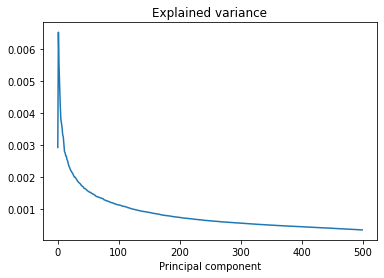

In [71]:
plt.plot(range(500), svd.explained_variance_ratio_[:500])
plt.gca().set_title('Explained variance');
plt.gca().set_xlabel('Principal component');

## Add the type information as OneHot vector

In [92]:
enc = OneHotEncoder()
enc.fit(np.asarray(df['type']).reshape(-1,1))

X_train_onehot = enc.transform(np.asarray(X_train['type']).reshape(-1,1))
X_test_onehot = enc.transform(np.asarray(X_test['type']).reshape(-1,1))

In [93]:
#import pickle 
#pickle.dump(enc, open('onehotenc.pkl', 'wb'))

In [94]:
from scipy.sparse import hstack

X_train_svd = hstack((X_train_svd, X_train_onehot))
X_test_svd = hstack((X_test_svd, X_test_onehot))

# Models

In [99]:
clf = LogisticRegression(max_iter=700, penalty='l2', warm_start=True, random_state=123).fit(X_train_svd, y_train)
clf.score(X_train_svd, y_train), clf.score(X_test_svd, y_test)

(0.5217361863488624, 0.5047851209823041)

In [96]:
#pickle.dump(clf, open('classifier3.pkl', 'wb') )

In [51]:
rfc = RandomForestClassifier(max_depth=7,n_estimators=256, n_jobs=-1, random_state=123).fit(X_train_svd, y_train)
rfc.score(X_train_svd, y_train), rfc.score(X_test_svd, y_test)

(0.4974045545880777, 0.454370395177495)

In [52]:
knn = KNeighborsClassifier(n_neighbors=10, p=2).fit(X_train_svd.toarray()[:,0:500], y_train)
knn.score(X_train_svd.toarray()[:,0:500], y_train), knn.score(X_test_svd.toarray()[:,0:500], y_test)

(0.5456086738111185, 0.4168620227729404)

In [51]:
mlp = MLPClassifier(hidden_layer_sizes=(15,10,5), max_iter=500, activation='relu', early_stopping=True, warm_start=True, random_state=123).fit(X_train_svd, y_train)
mlp.score(X_train_svd, y_train), mlp.score(X_test_svd, y_test)

(0.5226682853315472, 0.500669792364367)

# Fine-tuning

In [ ]:
lr = LogisticRegression(max_iter=700, penalty='l2', warm_start=True, fit_intercept=True, random_state=123).fit(X_train_svd, y_train)
orig_coef = lr.coef_.copy()
print("General: ", lr.score(X_train_svd, y_train), lr.score(X_test_svd, y_test))

for proj in good_projects:
    lr = LogisticRegression(max_iter=700, penalty='l2', warm_start=True, fit_intercept=True, random_state=123).fit(X_train_svd, y_train)

    X_train_svd2 = X_train_svd.toarray()[X_train['project_id'] == proj,:]
    X_test_svd2 = X_test_svd.toarray()[X_test['project_id'] == proj,:]
    y_train2 = y_train[X_train['project_id'] == proj]
    y_test2 = y_test[X_test['project_id'] == proj]
    try:
        lr.fit(X_train_svd2, y_train2)
        print(f"{proj}: ", lr.score(X_train_svd2, y_train2), lr.score(X_test_svd2, y_test2))
    except:
        print(f"{proj}: ???")
    

General:  0.6634084058941728 0.6560616208975217
org.apache:felix:  0.7037671232876712 0.6318537859007833
org.apache:cayenne:  0.7265917602996255 0.6464285714285715
org.apache:net:  0.6943231441048034 0.5616438356164384
org.apache:codec:  0.7426470588235294 0.6875
org.apache:ognl:  0.8148148148148148 0.5
accumulo:  0.6957065443934973 0.618018018018018
org.apache:santuario:  0.6388888888888888 0.68
org.apache:zookeeper:  0.7470817120622568 0.7302798982188295
org.apache:cocoon:  0.7058823529411765 0.6078431372549019
org.apache:httpclient:  0.6608084358523726 0.56875
aurora:  0.6902106567534076 0.6302083333333334
org.apache:httpcore:  0.7002724795640327 0.6710526315789473
org.apache:vfs:  0.7967213114754098 0.6282051282051282
org.apache:beanutils:  0.7297297297297297 0.5625
org.apache:collections:  0.7155963302752294 0.625
org.apache:bcel:  0.8045977011494253 0.6666666666666666
org.apache:commons-fileupload:  0.6790123456790124 0.5238095238095238
org.apache:configuration:  0.73026315789473

# Example of Usage

In [22]:
example = "problem connect database server access host URL"
vec = vectorizer.transform([example])
np.where(vec.todense() != 0)[1], vec[vec != 0]

(array([ 7927, 17161, 19152, 30404, 45337, 51565, 62693]),
 matrix([[0.4333874 , 0.49014179, 0.42175007, 0.32731719, 0.33931625,
          0.29170108, 0.2944515 ]]))

In [48]:
print(svd.transform(vec))

[[ 1.59020101e-01 -8.61740893e-02  2.30916304e-02  2.72452873e-02
  -7.47087360e-02 -2.36682590e-01  1.79440184e-02 -9.20618245e-02
   2.83661976e-02 -5.48886545e-02  9.50063720e-02  9.96040575e-03
  -5.21584001e-03 -1.14625038e-01 -9.12156243e-03 -2.68946365e-02
  -1.03235152e-01 -8.80194703e-02  7.60921849e-02 -1.45645185e-01
  -9.05452149e-02 -7.22527384e-02  1.17961798e-01  3.04041198e-02
   6.61425771e-02  3.83440835e-02 -1.25269967e-01 -4.33458433e-02
  -7.91939970e-02 -3.82247893e-02  4.93949542e-03 -7.90190605e-02
   8.02078890e-02 -6.15467674e-02  6.20655799e-02  4.71443579e-03
   2.20548916e-02 -4.27351000e-02 -3.69460923e-02  6.15977043e-02
  -2.73892610e-02  3.05304468e-02 -3.75701052e-03  5.30915311e-02
  -3.43068094e-03 -3.99186872e-02 -3.52791859e-02 -2.48907292e-02
   2.12661319e-02  1.70851096e-02 -1.08779341e-02  8.18292509e-02
  -3.54123442e-03 -3.10538156e-02 -1.77963336e-03 -3.12620437e-02
  -5.10171781e-03 -8.66606742e-02  4.11623074e-02  3.97571395e-02
  -3.81655